# Analysis of the characteristics of job offers advertised by employers in France, with a particular focus on both wage and non-wage job attributes. 

The study has three main objectives. First, we aim to identify the most common paid and non-paid job attributes that are explicitly mentioned by employers in job ads. Second, we analyze how the presence and type of these attributes vary across sectors and geographic regions. Third, we focus on the subset of job offers that explicitly disclose wages, to examine whether and how their advertised non-wage attributes differ from those that do not mention salary.

In [47]:
# Check how many unique 'famille_pro22' values exist for each 'famille_pro87'
mapping_check = df.groupby('famille_pro87')['famille_pro22'].nunique().reset_index()

# Show how many 'famille_pro87' map to multiple 'famille_pro22'
multi_mapped = mapping_check[mapping_check['famille_pro22'] > 1]
print(f"{len(multi_mapped)} famille_pro87 codes map to multiple famille_pro22 codes.")

# Optional: print some examples
print(multi_mapped.head())


0 famille_pro87 codes map to multiple famille_pro22 codes.
Empty DataFrame
Columns: [famille_pro87, famille_pro22]
Index: []


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import zipfile
import os

In [33]:
import psutil
print(f"RAM used: {psutil.virtual_memory().used / 1e9:.2f} GB")


RAM used: 6.81 GB


In [31]:
# Define the path to the zip file
zip_path = "final_dataset.csv.zip"

# Unzip the file to the current directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # This will extract to the current working directory

# List files in current directory to confirm the extracted filename
for file in os.listdir():
    if file.endswith(".csv"):
        csv_filename = file
        break  # Stop after finding the first CSV file

# Load the extracted CSV into a DataFrame
df = pd.read_csv(csv_filename)




C:\Users\sofia\AppData\Local\Temp\ipykernel_9780\1151342501.py:15: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_filename)


MemoryError: Unable to allocate 2.76 GiB for an array with shape (59, 6273405) and data type int64

In [56]:
# Display basic info and the first few rows of the DataFrame
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (6262574, 63)

Column names: ['location_departement', 'departement_nom', 'famille_pro22', 'famille_pro87', 'is_salary', 'Autonomie_dans_l’exécution_des_tâches', 'Bel_emplacement', 'Bonne_rémunération_des_heures_supplémentaires', 'Bonnes_perspectives_de_carrière', 'Bons_collègues', 'Chalet_d’entreprise', 'Choix_entre_temps_plein_et_temps_partiel', 'Chèques_vacance', 'Congés_flexibles/étendus', 'Contrat_à_durée_déterminée', 'Contrat_à_temps_partiel', 'Contrat_à_temps_plein', 'Emplacement_central', 'Emploi_permanent', 'Emploi_sur_appel', 'Emploi_temporaire', 'Environnement_social', 'Espace_de_bureau_partagé', 'Exemption_des_réglementations_sur_le_temps_de_travail', 'Formation_en_cours_d’emploi', 'Heures_supplémentaires_requises', 'Horaire_de_travail_de_jour_régulier', 'Niveau_de_rémunération', 'Place_de_parking_sur_site', 'Possibilité_de_télétravail', 'Possibilité_d’emprunt_immobilier', 'Possibilité_d’horaires_flexibles', 'Prime_à_l’embauche', 'Programme_d’inclusion_travail

## Descriptive statistics

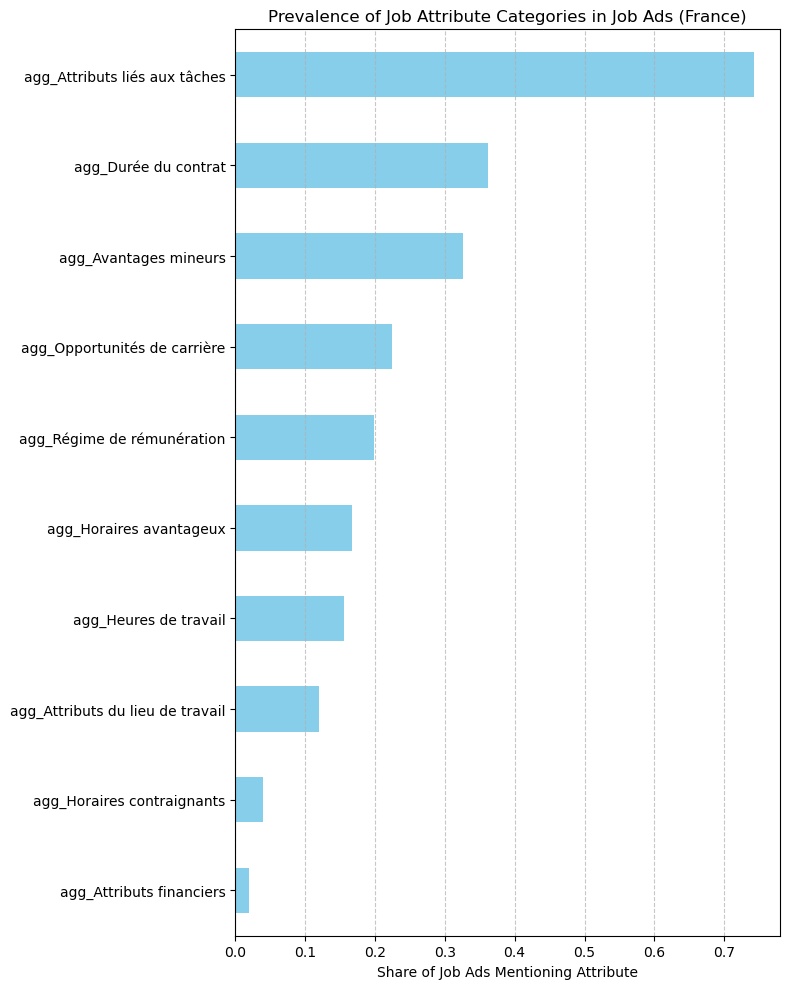

In [5]:
# Step 1 — Select only the 'agg_' columns (aggregated attribute categories)
agg_columns = [col for col in df.columns if col.startswith("agg_")]

# Step 2 — Calculate the share of job ads that mention each aggregated attribute
agg_shares = df[agg_columns].mean().sort_values()

# Step 3 — Plot the horizontal bar chart
plt.figure(figsize=(8, 10))
agg_shares.plot(kind='barh', color='skyblue')

# Step 4 — Add labels and title
plt.xlabel("Share of Job Ads Mentioning Attribute")
plt.title("Prevalence of Job Attribute Categories in Job Ads (France)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


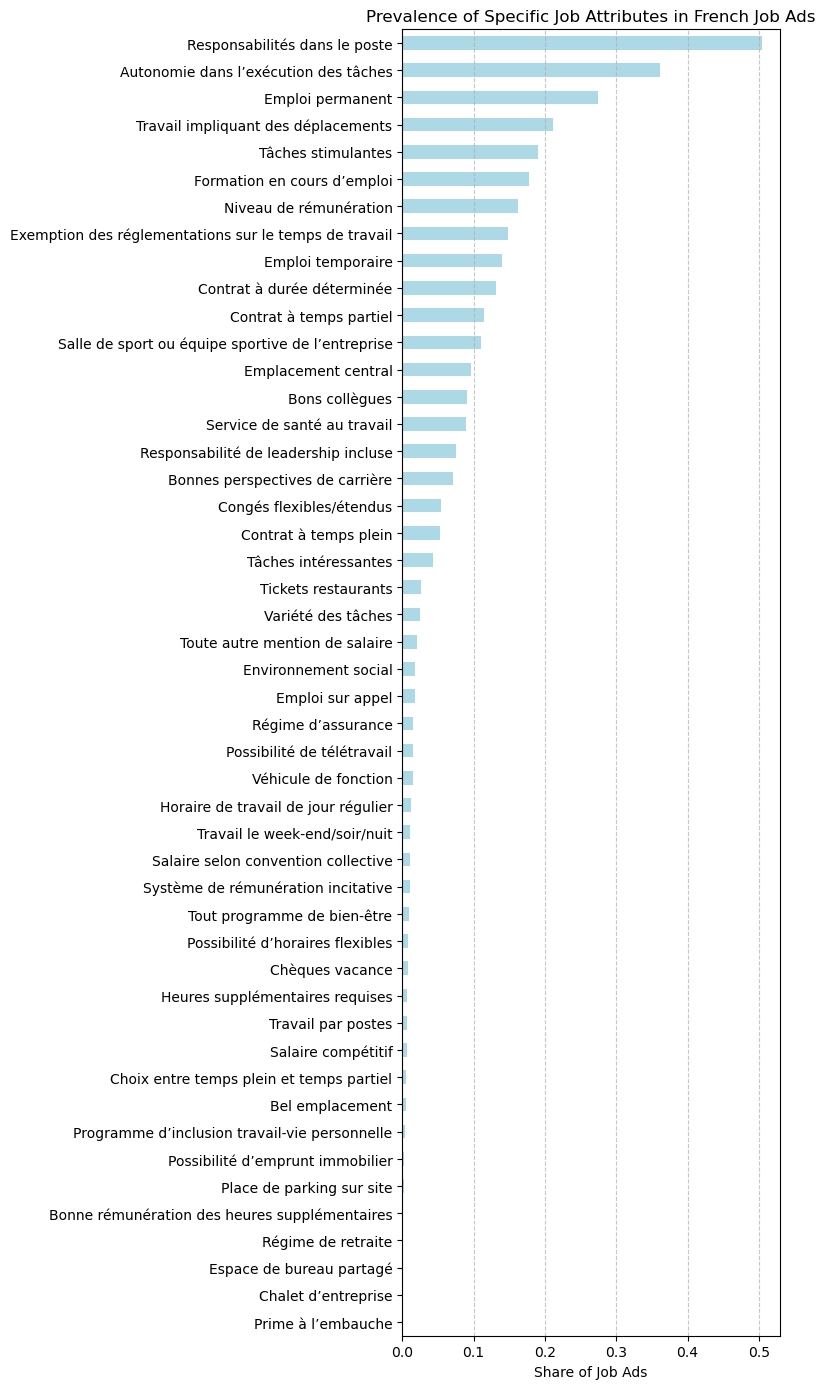

In [6]:
# Step 1 — Filter specific job attribute columns (exclude 'agg_' and metadata)
context_vars = ['location_departement', 'departement_nom', 'famille_pro22', 'famille_pro87', 'is_salary']
attribute_cols = [col for col in df.columns if col not in context_vars and not col.startswith("agg_")]

# Step 2 — Calculate prevalence of each specific attribute
attr_shares = df[attribute_cols].mean().sort_values()

# Step 3 — Plot
plt.figure(figsize=(8, 14))
attr_shares.plot(kind='barh', color='lightblue')

plt.xlabel("Share of Job Ads")
plt.title("Prevalence of Specific Job Attributes in French Job Ads")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
attribute_groups = {
    'Attributs du lieu de travail': [
        'Bons collègues',
        'Environnement social',
        'Espace de bureau partagé',
        'Possibilité de télétravail',
        'Programme d’inclusion travail-vie personnelle'
    ],
    'Attributs financiers': [
        'Possibilité d’emprunt immobilier',
        'Régime d’assurance',
        'Régime de retraite'
    ],
    'Attributs liés aux tâches': [
        'Autonomie dans l’exécution des tâches',
        'Responsabilité de leadership incluse',
        'Responsabilités dans le poste',
        'Tâches intéressantes',
        'Tâches stimulantes',
        'Travail impliquant des déplacements',
        'Variété des tâches'
    ],
    'Avantages mineurs': [
        'Bel emplacement',
        'Chalet d’entreprise',
        'Congés flexibles/étendus',
        'Emplacement central',
        'Place de parking sur site',
        'Salle de sport ou équipe sportive de l’entreprise',
        'Service de santé au travail',
        'Tout programme de bien-être',
        'Véhicule de fonction'
    ],
    'Durée du contrat': [
        'Contrat à durée déterminée',
        'Emploi permanent',
        'Emploi temporaire'
    ],
    'Heures de travail': [
        'Choix entre temps plein et temps partiel',
        'Contrat à temps partiel',
        'Contrat à temps plein'
    ],
    'Horaires avantageux': [
        'Exemption des réglementations sur le temps de travail',
        'Horaire de travail de jour régulier',
        'Possibilité d’horaires flexibles'
    ],
    'Horaires contraignants': [
        'Emploi sur appel',
        'Heures supplémentaires requises',
        'Travail le week-end/soir/nuit',
        'Travail par postes'
    ],
    'Opportunités de carrière': [
        'Bonnes perspectives de carrière',
        'Formation en cours d’emploi'
    ],
    'Régime de rémunération': [
        'Bonne rémunération des heures supplémentaires',
        'Niveau de rémunération',
        'Prime à l’embauche',
        'Salaire compétitif',
        'Salaire selon convention collective',
        'Système de rémunération incitative',
        'Toute autre mention de salaire'
    ]
}


In [36]:
# Dictionary to store results
plot_data = []

# Loop through each group and calculate share for each attribute
for category, attributes in attribute_groups.items():
    for attr in attributes:
        if attr in df.columns:
            share = df[attr].mean()
            plot_data.append({
                'Category': category.replace('agg_', ''),  # cleaner label
                'Attribute': attr,
                'Share': share
            })

# Create DataFrame from results
plot_df = pd.DataFrame(plot_data)


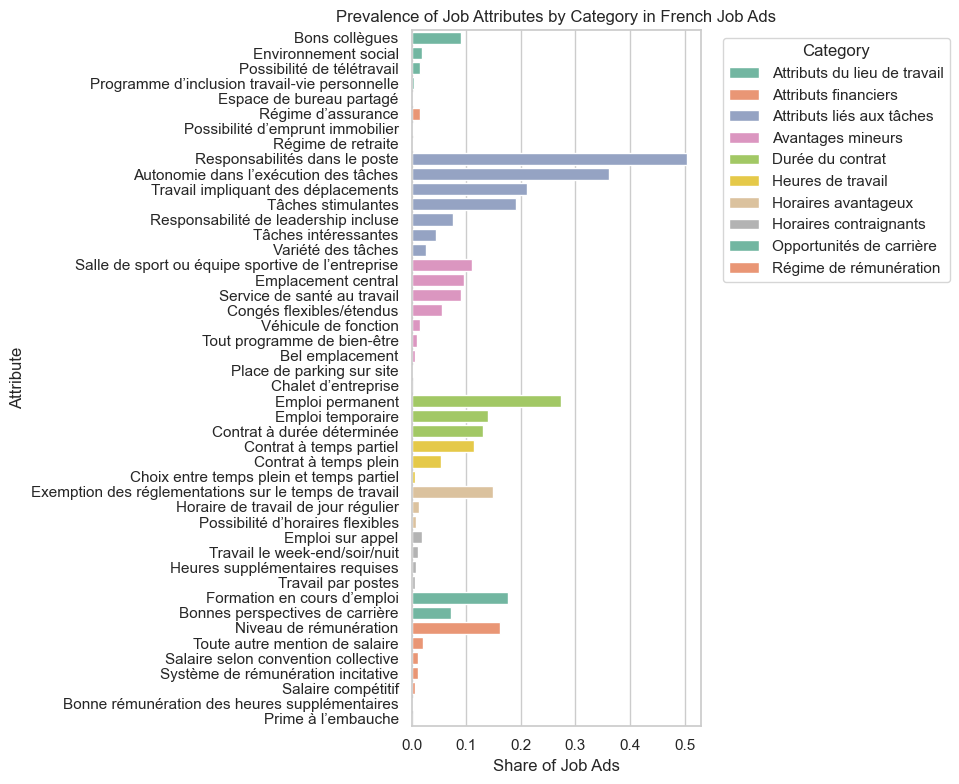

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure aesthetics
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Sort attributes within categories
plot_df = plot_df.sort_values(by=['Category', 'Share'], ascending=[True, False])

# Plot grouped horizontal bar chart
sns.barplot(
    data=plot_df,
    y="Attribute",
    x="Share",
    hue="Category",
    dodge=False,
    palette="Set2"
)

# Customize plot
plt.title("Prevalence of Job Attributes by Category in French Job Ads")
plt.xlabel("Share of Job Ads")
plt.ylabel("Attribute")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


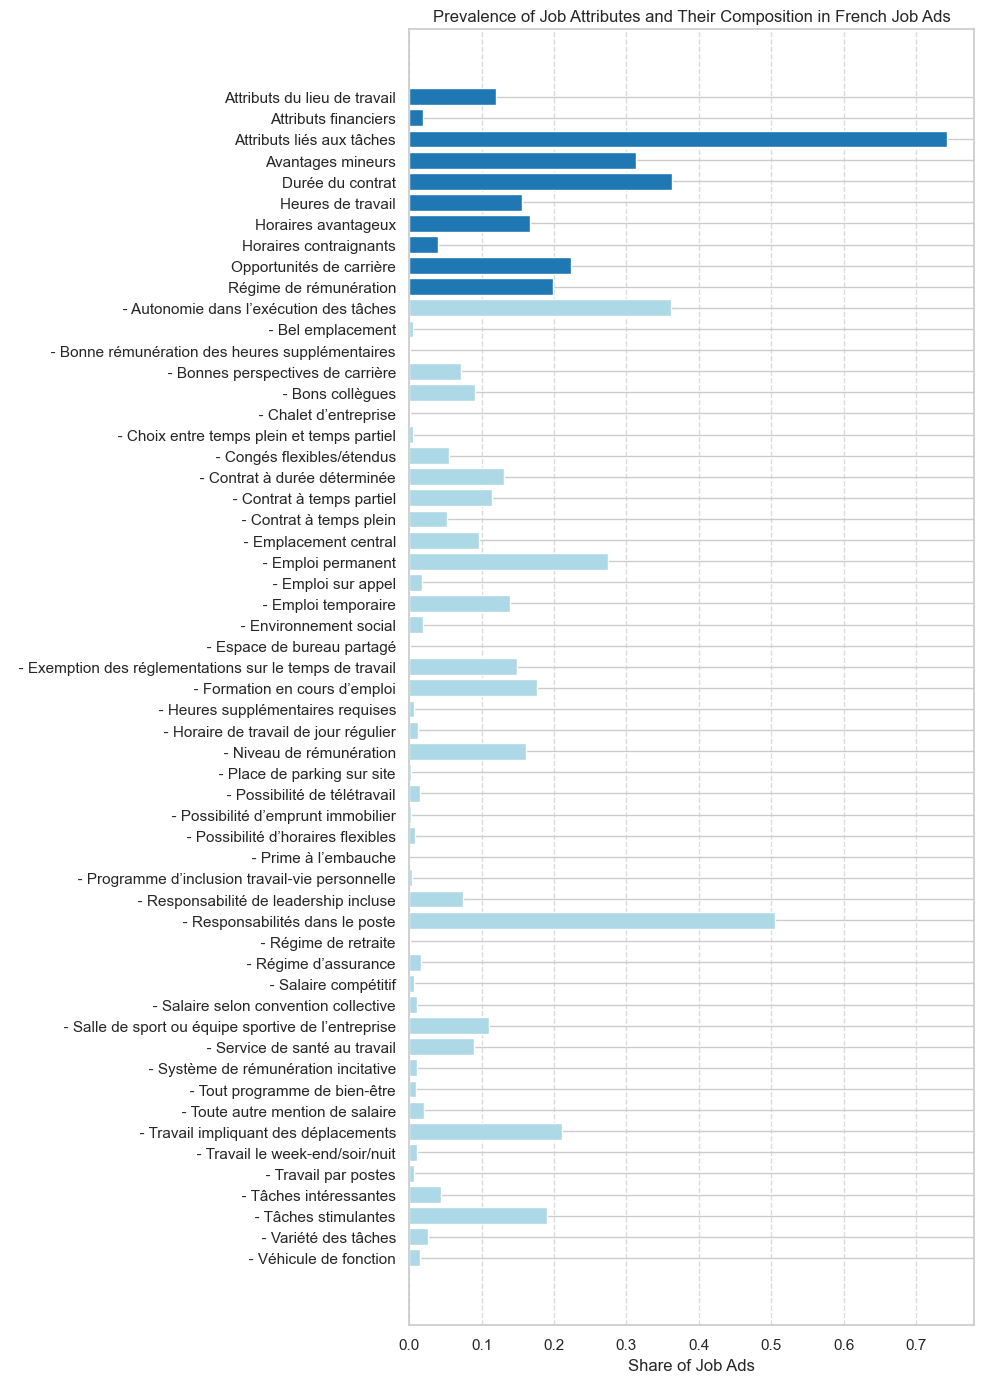

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Define your attribute_groups dictionary first (already provided in mensaje anterior)

# Step 1 — Compute share for each attribute and for each group
plot_data = []

for category, subattributes in attribute_groups.items():
    total_group_share = df[subattributes].any(axis=1).mean()  # Share of ads with any of the subattributes
    plot_data.append({
        'Attribute': category,
        'Share': total_group_share,
        'Type': 'Category'
    })
    for attr in subattributes:
        if attr in df.columns:
            share = df[attr].mean()
            plot_data.append({
                'Attribute': f'  - {attr}',  # Indent for subattributes
                'Share': share,
                'Type': 'Subattribute'
            })

# Create DataFrame
plot_df = pd.DataFrame(plot_data)

# Step 2 — Sort for visual clarity (grouped)
plot_df['SortKey'] = plot_df['Attribute'].apply(lambda x: x if not x.startswith("  -") else f"zzz_{x}")
plot_df = plot_df.sort_values(by='SortKey', ascending=False)

# Step 3 — Plot
plt.figure(figsize=(10, 14))

for idx, row in plot_df.iterrows():
    color = '#1f77b4' if row['Type'] == 'Category' else '#add8e6'  # Dark blue for categories, light blue for subattributes
    plt.barh(row['Attribute'], row['Share'], color=color)

# Formatting
plt.xlabel("Share of Job Ads")
plt.title("Prevalence of Job Attributes and Their Composition in French Job Ads")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


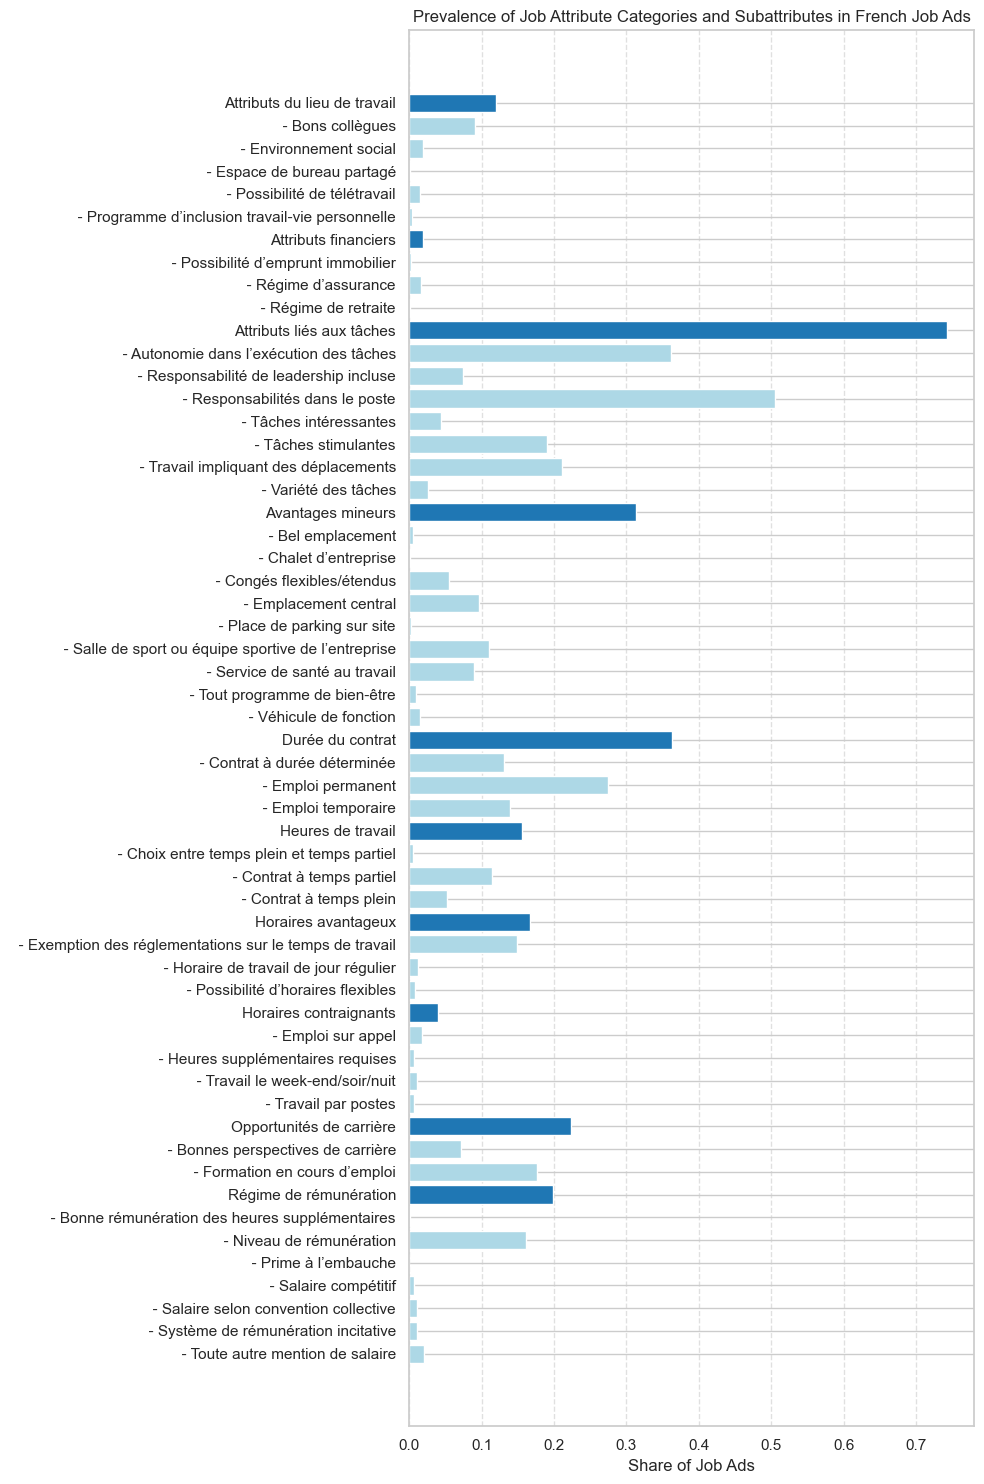

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Define your attribute_groups dictionary here (already done before)

# Step 1 — Build plot data with fixed ordering: category first, then its subattributes
plot_data = []

for category, subattributes in attribute_groups.items():
    # Calculate share of ads that mention any attribute in the group
    group_share = df[subattributes].any(axis=1).mean()
    plot_data.append({
        'Label': category,
        'Share': group_share,
        'Type': 'Category'
    })
    
    # Add each subattribute with its individual share
    for attr in subattributes:
        if attr in df.columns:
            attr_share = df[attr].mean()
            plot_data.append({
                'Label': f'  - {attr}',  # Indent to show nesting
                'Share': attr_share,
                'Type': 'Subattribute'
            })

# Step 2 — Create a DataFrame and preserve insertion order
plot_df = pd.DataFrame(plot_data)

# Step 3 — Plot with correct hierarchical ordering
plt.figure(figsize=(10, 15))

for idx, row in plot_df.iterrows():
    color = '#1f77b4' if row['Type'] == 'Category' else '#add8e6'
    plt.barh(row['Label'], row['Share'], color=color)

# Step 4 — Formatting
plt.xlabel("Share of Job Ads")
plt.title("Prevalence of Job Attribute Categories and Subattributes in French Job Ads")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # To show top-down hierarchy
plt.tight_layout()
plt.show()


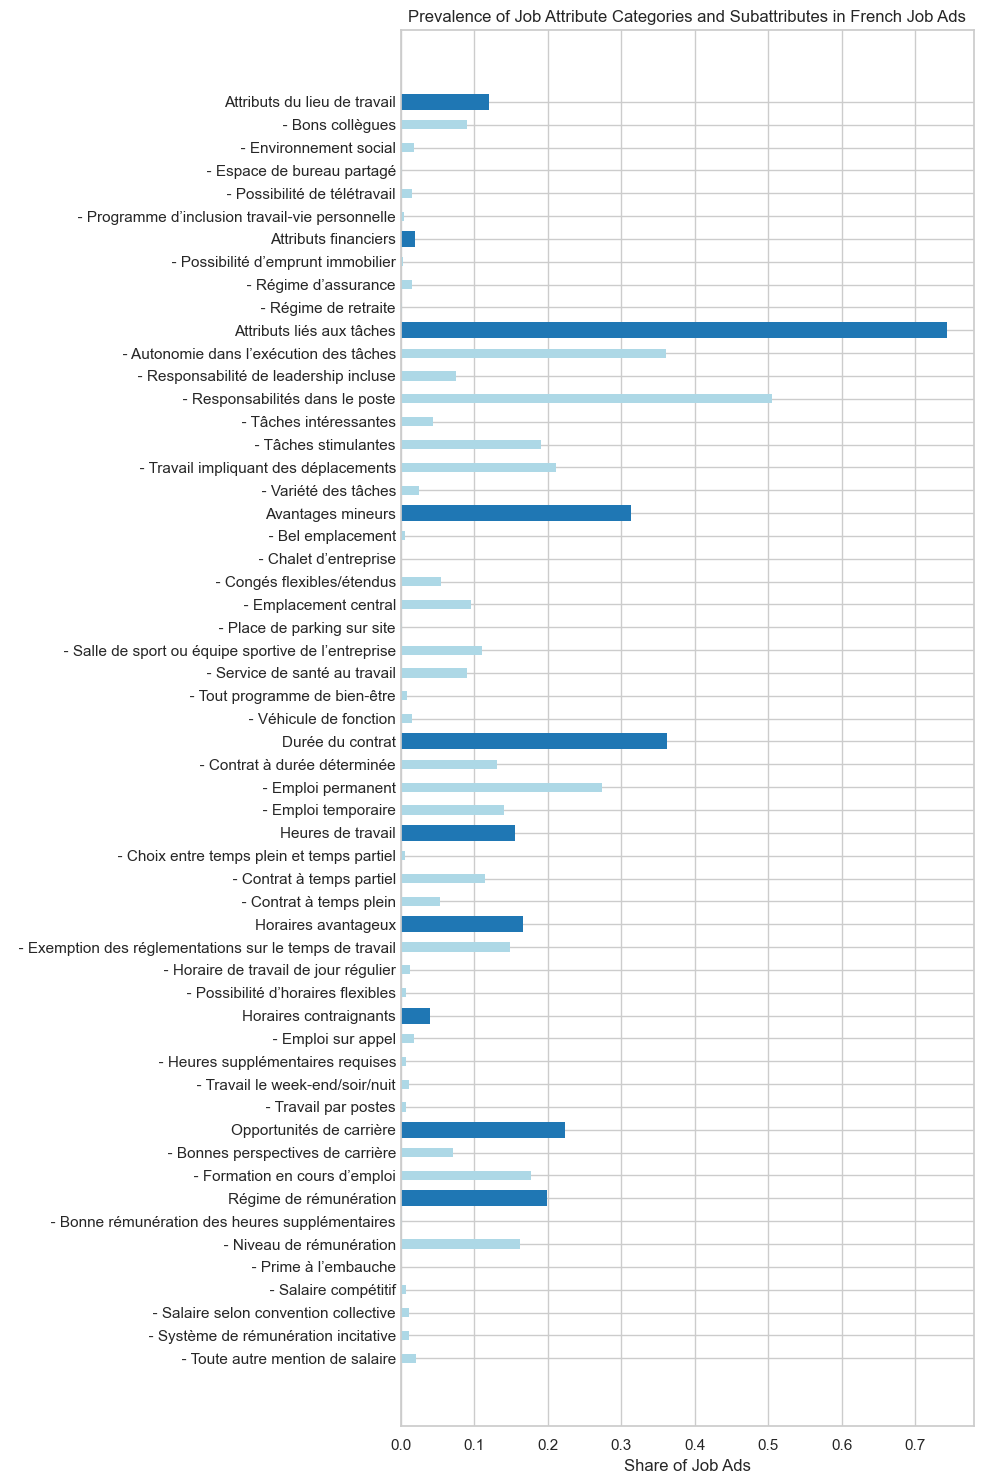

In [13]:
import matplotlib.pyplot as plt

# Plot configuration
fig, ax = plt.subplots(figsize=(10, 15))

# Bar plot with dynamic coloring
for idx, row in plot_df.iterrows():
    color = '#1f77b4' if row['Type'] == 'Category' else '#add8e6'
    ax.barh(
        y=idx, 
        width=row['Share'], 
        color=color, 
        edgecolor='none',      # Removes the border/line
        height=0.7 if row['Type'] == 'Category' else 0.4  # Thinner subattribute bars
    )

# Set y-ticks and labels
ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df['Label'])

# Invert axis to show top-down hierarchy
ax.invert_yaxis()

# Axis labels and title
ax.set_xlabel("Share of Job Ads")
ax.set_title("Prevalence of Job Attribute Categories and Subattributes in French Job Ads")

# Remove the small gray tick lines on y-axis
ax.tick_params(axis='y', length=0)

# Optional: tighter layout to remove padding
plt.tight_layout()
plt.show()


In [37]:
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)


In [38]:
def tabulate_categorical(df, column, sort=True, normalize=True):
    """
    Prints a Stata-style tabulation of a categorical variable in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: string, column name
    - sort: whether to sort by frequency
    - normalize: whether to include relative frequencies
    """
    counts = df[column].value_counts(dropna=False, sort=sort)
    total = counts.sum()
    
    tab_df = counts.to_frame(name='Count')
    if normalize:
        tab_df['Percent'] = 100 * tab_df['Count'] / total
        tab_df['Percent'] = tab_df['Percent'].round(2)
    
    print(f"\nVariable: {column}")
    print(f"Unique categories: {df[column].nunique(dropna=False)}")
    display(tab_df)

# Example usage
tabulate_categorical(df, 'famille_pro22')
tabulate_categorical(df, 'location_departement')
tabulate_categorical(df, 'famille_pro87')



Variable: famille_pro22
Unique categories: 22


,Count,Percent
Commerce,1012831,16.14
"Gestion, administration des entreprises",979105,15.61
"Bâtiment, travaux publics",691290,11.02
Informatique et télécommunications,594131,9.47
"Santé, action sociale, culturelle et sportive",501444,7.99
"Transports, logistique et tourisme",374932,5.98
Maintenance,374891,5.98
Services aux particuliers et aux collectivités,343801,5.48
"Hôtellerie, restauration, alimentation",302647,4.82
"Mécanique, travail des métaux",266376,4.25



Variable: location_departement
Unique categories: 115


,Count,Percent
75,612662,9.77
92,381479,6.08
69,326772,5.21
44,204990,3.27
59,199795,3.18
...,...,...
988,495,0.01
4,274,0.00
5,210,0.00
987,82,0.00



Variable: famille_pro87
Unique categories: 83


,Count,Percent
Cadres commerciaux et technico-commerciaux,436348,6.96
"Cadres des services administratifs, comptables et financiers",421706,6.72
Employés et opérateurs de l'informatique,322266,5.14
Techniciens et agents de maîtrise du bâtiment et des travaux publics,301372,4.80
Techniciens et agents de maîtrise de la maintenance,299182,4.77
...,...,...
Ouvriers qualifiés du gros œuvre du bâtiment,1186,0.02
Professions intermédiaires administratives de la fonction publique (catégorie B et assimilés),690,0.01
Employés administratifs de la fonction publique (catégorie C et assimilés),488,0.01
"Techniciens des services administratifs, comptables et financiers",179,0.00


In [39]:
def clean_departement_column(df, column):
    # Convert to string and strip spaces
    df[column] = df[column].astype(str).str.strip()

    # Remove trailing ".0" if present
    df[column] = df[column].str.replace(r'\.0$', '', regex=True)

    # Replace known invalid entries 
    invalids = ['nan', '', 'NaN', 'None', '0', '00']
    df[column] = df[column].where(~df[column].isin(invalids), other=pd.NA)

    return df

# Apply cleaning function
df = clean_departement_column(df, 'location_departement')

# Check again
tabulate_categorical(df, 'location_departement')



Variable: location_departement
Unique categories: 115


,Count,Percent
75,612662,9.77
92,381479,6.08
69,326772,5.21
44,204990,3.27
59,199795,3.18
...,...,...
988,495,0.01
4,274,0.00
5,210,0.00
987,82,0.00


In [40]:
def tabulate_categorical(df, column, sort=True, normalize=True):
    """
    Prints a Stata-style tabulation of a categorical variable in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: string, column name
    - sort: whether to sort by frequency
    - normalize: whether to include relative frequencies
    """
    counts = df[column].value_counts(dropna=False, sort=sort)
    total = counts.sum()
    
    tab_df = counts.to_frame(name='Count')
    if normalize:
        tab_df['Percent'] = 100 * tab_df['Count'] / total
        tab_df['Percent'] = tab_df['Percent'].round(2)
    
    print(f"\nVariable: {column}")
    print(f"Unique categories: {df[column].nunique(dropna=False)}")
    display(tab_df)

# Example usage
tabulate_categorical(df, 'famille_pro22')
tabulate_categorical(df, 'location_departement')
tabulate_categorical(df, 'famille_pro87')



Variable: famille_pro22
Unique categories: 22


,Count,Percent
Commerce,1012831,16.14
"Gestion, administration des entreprises",979105,15.61
"Bâtiment, travaux publics",691290,11.02
Informatique et télécommunications,594131,9.47
"Santé, action sociale, culturelle et sportive",501444,7.99
"Transports, logistique et tourisme",374932,5.98
Maintenance,374891,5.98
Services aux particuliers et aux collectivités,343801,5.48
"Hôtellerie, restauration, alimentation",302647,4.82
"Mécanique, travail des métaux",266376,4.25



Variable: location_departement
Unique categories: 115


,Count,Percent
75,612662,9.77
92,381479,6.08
69,326772,5.21
44,204990,3.27
59,199795,3.18
...,...,...
988,495,0.01
4,274,0.00
5,210,0.00
987,82,0.00



Variable: famille_pro87
Unique categories: 83


,Count,Percent
Cadres commerciaux et technico-commerciaux,436348,6.96
"Cadres des services administratifs, comptables et financiers",421706,6.72
Employés et opérateurs de l'informatique,322266,5.14
Techniciens et agents de maîtrise du bâtiment et des travaux publics,301372,4.80
Techniciens et agents de maîtrise de la maintenance,299182,4.77
...,...,...
Ouvriers qualifiés du gros œuvre du bâtiment,1186,0.02
Professions intermédiaires administratives de la fonction publique (catégorie B et assimilés),690,0.01
Employés administratifs de la fonction publique (catégorie C et assimilés),488,0.01
"Techniciens des services administratifs, comptables et financiers",179,0.00


In [41]:
# Define key variables where you want no missing values
key_vars = ['famille_pro22', 'famille_pro87', 'location_departement']

# Drop rows with NaN in those columns, modifying the original DataFrame
df.dropna(subset=key_vars, inplace=True)

# Check how many rows remain
print(f"Remaining rows after filtering: {df.shape[0]:,}")



Remaining rows after filtering: 6,262,574


In [51]:
# Take a random sample of 100,000 rows
df_sample = df.sample(n=200_000, random_state=42)

# Check shape
print(f"Sample size: {df_sample.shape[0]:,} rows")


Sample size: 200,000 rows


In [52]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Correct formula with double quotes for the dependent variable
formula = 'agg_Attributs_du_lieu_de_travail ~ C(famille_pro22) + C(location_departement)'

# Estimate the logistic regression
model = smf.logit(formula=formula, data=df_sample).fit()

# Print model summary
print(model.summary())

# Print pseudo R²
print("\nMcFadden's Pseudo R²:", model.prsquared)


         Current function value: 0.354403
         Iterations: 35


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Logit Regression Results                                  
Dep. Variable:     agg_Attributs_du_lieu_de_travail   No. Observations:               200000
Model:                                        Logit   Df Residuals:                   199866
Method:                                         MLE   Df Model:                          133
Date:                              Tue, 20 May 2025   Pseudo R-squ.:                 0.03070
Time:                                      02:09:46   Log-Likelihood:                -70881.
converged:                                    False   LL-Null:                       -73126.
Covariance Type:                          nonrobust   LLR p-value:                     0.000
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------

In [53]:
import statsmodels.formula.api as smf
import pandas as pd

# List of agg_ attributes
agg_attributes = [col for col in df_sample.columns if col.startswith("agg_")]

# Store results here
r2_results = []

# Loop over each attribute
for attr in agg_attributes:
    print(f"Running logit for: {attr}")
    formula = f'Q("{attr}") ~ C(famille_pro22) + C(location_departement)'
    
    try:
        model = smf.logit(formula=formula, data=df_sample).fit(disp=0)
        r2_results.append({
            "Attribute": attr.replace("agg_", ""),
            "Pseudo_R2": model.prsquared
        })
    except Exception as e:
        print(f"⚠️ Failed for {attr}: {e}")

# Convert to DataFrame
r2_df = pd.DataFrame(r2_results)

# Show results
print("\nPseudo R² summary:")
print(r2_df.sort_values(by="Pseudo_R2", ascending=False))


Running logit for: agg_Attributs_du_lieu_de_travail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Attributs_financiers


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for agg_Attributs_financiers: Singular matrix
Running logit for: agg_Attributs_liés_aux_tâches


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Avantages_mineurs


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Durée_du_contrat


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Heures_de_travail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Horaires_avantageux


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Horaires_contraignants


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Opportunités_de_carrière


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: agg_Régime_de_rémunération


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Pseudo R² summary:
                      Attribute  Pseudo_R2
6        Horaires_contraignants   0.056120
2             Avantages_mineurs   0.037958
4             Heures_de_travail   0.036535
1     Attributs_liés_aux_tâches   0.034573
3              Durée_du_contrat   0.033916
5           Horaires_avantageux   0.032121
0  Attributs_du_lieu_de_travail   0.030700
8        Régime_de_rémunération   0.023743
7      Opportunités_de_carrière   0.021674


In [57]:
# 1. Detect valid subattribute columns
sub_attributes = [
    col for col in df_sample.columns
    if not col.startswith("agg_")                                # no es categoría agregada
    and col != "is_salary"                                       # excluir is_salary
    and df_sample[col].dropna().isin([0, 1]).all()               # dummy 0/1
    and df_sample[col].nunique() > 1                             # tiene varianza
]

# 2. Almacenar resultados
sub_r2_results = []

# 3. Loop de logit
for attr in sub_attributes:
    print(f"Running logit for: {attr}")
    formula = f'Q("{attr}") ~ C(famille_pro22) + C(location_departement)'
    
    try:
        model = smf.logit(formula=formula, data=df_sample).fit(disp=0)
        sub_r2_results.append({
            "Attribute": attr,
            "Pseudo_R2": model.prsquared
        })
    except Exception as e:
        print(f"⚠️ Failed for {attr}: {e}")

# 4. Resultados
sub_r2_df = pd.DataFrame(sub_r2_results)
print("\nPseudo R² summary for subattributes:")
print(sub_r2_df.sort_values(by="Pseudo_R2", ascending=False))


Running logit for: Autonomie_dans_l’exécution_des_tâches


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Bel_emplacement


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Bel_emplacement: Singular matrix
Running logit for: Bonne_rémunération_des_heures_supplémentaires


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Bonne_rémunération_des_heures_supplémentaires: Singular matrix
Running logit for: Bonnes_perspectives_de_carrière


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Bons_collègues


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Chalet_d’entreprise


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Chalet_d’entreprise: Singular matrix
Running logit for: Choix_entre_temps_plein_et_temps_partiel


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Choix_entre_temps_plein_et_temps_partiel: Singular matrix
Running logit for: Chèques_vacance


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Chèques_vacance: Singular matrix
Running logit for: Congés_flexibles/étendus


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


⚠️ Failed for Congés_flexibles/étendus: Singular matrix
Running logit for: Contrat_à_durée_déterminée


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Contrat_à_temps_partiel


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Contrat_à_temps_plein


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Contrat_à_temps_plein: Singular matrix
Running logit for: Emplacement_central


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Emploi_permanent


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Emploi_sur_appel


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


⚠️ Failed for Emploi_sur_appel: Singular matrix
Running logit for: Emploi_temporaire


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Environnement_social


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Environnement_social: Singular matrix
Running logit for: Espace_de_bureau_partagé


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Espace_de_bureau_partagé: Singular matrix
Running logit for: Exemption_des_réglementations_sur_le_temps_de_travail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Formation_en_cours_d’emploi


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Heures_supplémentaires_requises


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Heures_supplémentaires_requises: Singular matrix
Running logit for: Horaire_de_travail_de_jour_régulier


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Niveau_de_rémunération


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Place_de_parking_sur_site


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Place_de_parking_sur_site: Singular matrix
Running logit for: Possibilité_de_télétravail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Possibilité_de_télétravail: Singular matrix
Running logit for: Possibilité_d’emprunt_immobilier


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Possibilité_d’emprunt_immobilier: Singular matrix
Running logit for: Possibilité_d’horaires_flexibles


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Possibilité_d’horaires_flexibles: Singular matrix
Running logit for: Prime_à_l’embauche


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Prime_à_l’embauche: Singular matrix
Running logit for: Programme_d’inclusion_travail-vie_personnelle


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Responsabilité_de_leadership_incluse


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Responsabilités_dans_le_poste


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Régime_de_retraite


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Régime_de_retraite: Singular matrix
Running logit for: Régime_d’assurance


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Régime_d’assurance: Singular matrix
Running logit for: Salaire_compétitif


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Salaire_compétitif: Singular matrix
Running logit for: Salaire_selon_convention_collective


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Salaire_selon_convention_collective: Singular matrix
Running logit for: Salle_de_sport_ou_équipe_sportive_de_l’entreprise


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Service_de_santé_au_travail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Système_de_rémunération_incitative


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Système_de_rémunération_incitative: Singular matrix
Running logit for: Tickets_restaurants


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Tickets_restaurants: Singular matrix
Running logit for: Tout_programme_de_bien-être


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Tout_programme_de_bien-être: Singular matrix
Running logit for: Toute_autre_mention_de_salaire


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Toute_autre_mention_de_salaire: Singular matrix
Running logit for: Travail_impliquant_des_déplacements


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Travail_le_week-end/soir/nuit


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Travail_par_postes


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Travail_par_postes: Singular matrix
Running logit for: Tâches_intéressantes


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Tâches_intéressantes: Singular matrix
Running logit for: Tâches_stimulantes


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Variété_des_tâches


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running logit for: Véhicule_de_fonction


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for Véhicule_de_fonction: Singular matrix

Pseudo R² summary for subattributes:
                                            Attribute  Pseudo_R2
16                        Service_de_santé_au_travail   0.124966
7                                   Emploi_temporaire   0.115700
10                Horaire_de_travail_de_jour_régulier   0.095293
18                      Travail_le_week-end/soir/nuit   0.094959
15  Salle_de_sport_ou_équipe_sportive_de_l’entreprise   0.085080
13               Responsabilité_de_leadership_incluse   0.064310
3                          Contrat_à_durée_déterminée   0.063648
12      Programme_d’inclusion_travail-vie_personnelle   0.063124
4                             Contrat_à_temps_partiel   0.046001
17                Travail_impliquant_des_déplacements   0.044970
8   Exemption_des_réglementations_sur_le_temps_de_...   0.044756
5                                 Emplacement_central   0.031212
19                                 Tâches_stimulantes   0.028068


## Looking into the logit for both variables

In [58]:
import statsmodels.formula.api as smf
import pandas as pd

# Lista de atributos 'agg_'
agg_attributes = [col for col in df_sample.columns if col.startswith("agg_")]

# Fórmulas con distintos efectos fijos
fe_sets = {
    "Industry FE": ["C(famille_pro22)"],
    "Location FE": ["C(location_departement)"],
    "Industry + Location": ["C(famille_pro22)", "C(location_departement)"]
}

# Lista para guardar resultados
pseudo_r2_results = []

# Loop por atributo y conjunto de controles
for attr in agg_attributes:
    print(f"\n🔍 Attribute: {attr}")
    
    for fe_label, variables in fe_sets.items():
        formula = f'Q("{attr}") ~ ' + " + ".join(variables)
        
        try:
            model = smf.logit(formula=formula, data=df_sample).fit(disp=0)
            pseudo_r2_results.append({
                "Attribute": attr.replace("agg_", ""),
                "FE_Set": fe_label,
                "Pseudo_R2": model.prsquared
            })
        except Exception as e:
            print(f"⚠️ Failed for {attr} with {fe_label}: {e}")



🔍 Attribute: agg_Attributs_du_lieu_de_travail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Attributs_financiers


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


⚠️ Failed for agg_Attributs_financiers with Industry + Location: Singular matrix

🔍 Attribute: agg_Attributs_liés_aux_tâches


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Avantages_mineurs


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Durée_du_contrat


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Heures_de_travail


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Horaires_avantageux


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Horaires_contraignants


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Opportunités_de_carrière


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔍 Attribute: agg_Régime_de_rémunération


C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [60]:
# Crear DataFrame de resultados
pseudo_r2_df = pd.DataFrame(pseudo_r2_results)

# Ordenar para revisión
pseudo_r2_df = pseudo_r2_df.sort_values(by=["Attribute", "FE_Set"])

# Mostrar resumen
print(pseudo_r2_df)


                       Attribute               FE_Set  Pseudo_R2
2   Attributs_du_lieu_de_travail  Industry + Location   0.030700
0   Attributs_du_lieu_de_travail          Industry FE   0.024753
1   Attributs_du_lieu_de_travail          Location FE   0.011129
3           Attributs_financiers          Industry FE   0.095442
4           Attributs_financiers          Location FE   0.012160
7      Attributs_liés_aux_tâches  Industry + Location   0.034573
5      Attributs_liés_aux_tâches          Industry FE   0.028891
6      Attributs_liés_aux_tâches          Location FE   0.011902
10             Avantages_mineurs  Industry + Location   0.037958
8              Avantages_mineurs          Industry FE   0.033764
9              Avantages_mineurs          Location FE   0.003602
13              Durée_du_contrat  Industry + Location   0.033916
11              Durée_du_contrat          Industry FE   0.022894
12              Durée_du_contrat          Location FE   0.012560
16             Heures_de_

In [61]:
# Aseguramos el orden deseado de efectos fijos
pseudo_r2_df["FE_Set"] = pd.Categorical(
    pseudo_r2_df["FE_Set"],
    categories=["Industry FE", "Location FE", "Industry + Location"],
    ordered=True
)


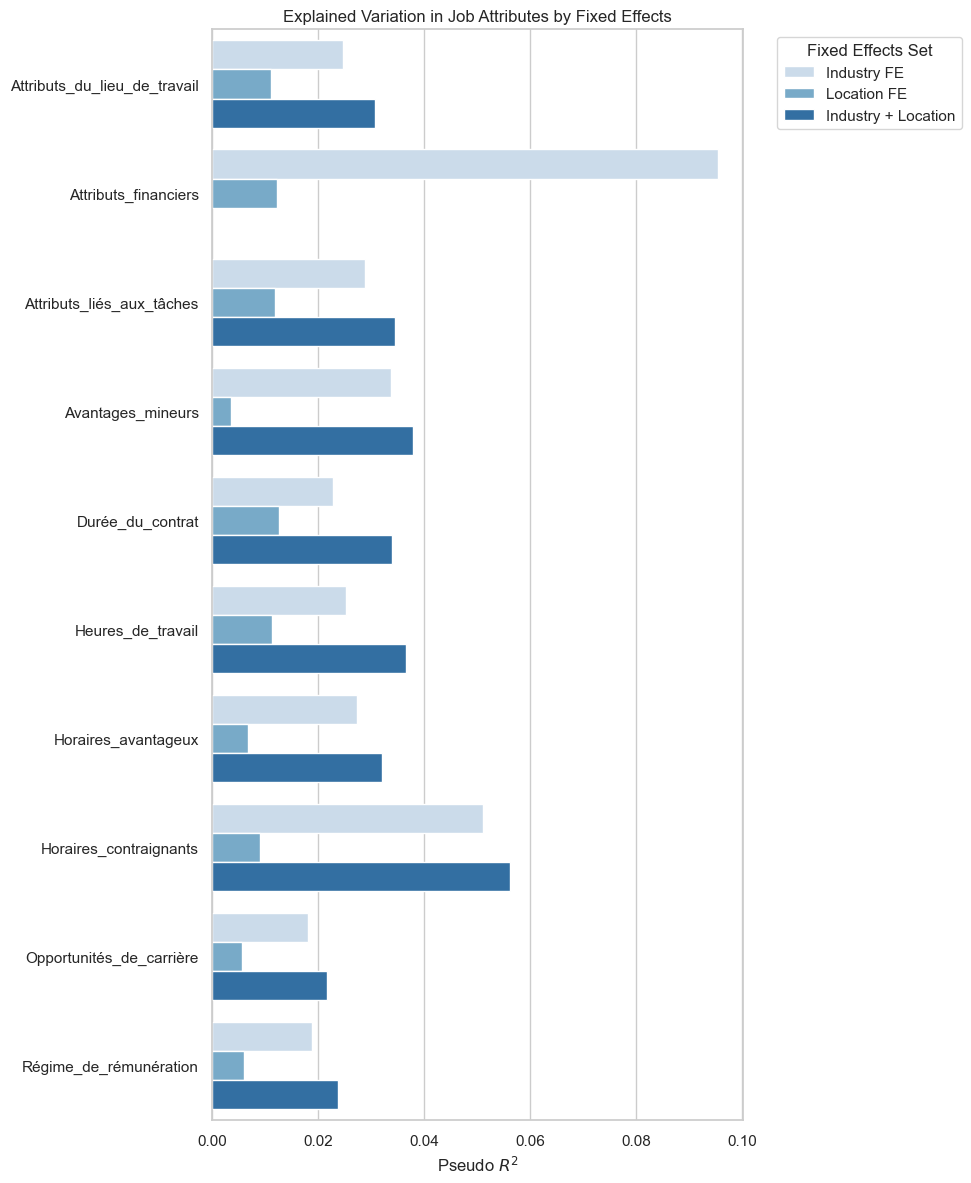

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aumentar tamaño y estilo
plt.figure(figsize=(10, 12))
sns.set(style="whitegrid")

# Gráfico de barras agrupadas
sns.barplot(
    data=pseudo_r2_df,
    x="Pseudo_R2",
    y="Attribute",
    hue="FE_Set",
    palette="Blues"
)

# Títulos y formato
plt.xlabel("Pseudo $R^2$")
plt.ylabel("")
plt.title("Explained Variation in Job Attributes by Fixed Effects")
plt.legend(title="Fixed Effects Set", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.formula.api as smf
import pandas as pd

# 1. Detect valid subattribute columns (binary dummies, excluding 'agg_' and 'is_salary')
sub_attributes = [
    col for col in df_sample.columns
    if not col.startswith("agg_")
    and col != "is_salary"
    and df_sample[col].dropna().isin([0, 1]).all()
    and df_sample[col].nunique() > 1
]

# 2. Define fixed effects sets
fe_sets = {
    "Industry FE": ["C(famille_pro22)"],
    "Location FE": ["C(location_departement)"],
    "Industry + Location": ["C(famille_pro22)", "C(location_departement)"]
}

# 3. Store results
sub_r2_results = []

# 4. Loop over subattributes and fixed effects
for attr in sub_attributes:
    print(f"\n🔍 Attribute: {attr}")
    
    for fe_label, variables in fe_sets.items():
        formula = f'Q("{attr}") ~ ' + " + ".join(variables)
        
        try:
            model = smf.logit(formula=formula, data=df_sample).fit(disp=0)
            sub_r2_results.append({
                "Attribute": attr,
                "FE_Set": fe_label,
                "Pseudo_R2": model.prsquared
            })
        except Exception as e:
            print(f"⚠️ Failed for {attr} with {fe_label}: {e}")


In [ ]:
# Convert to DataFrame
sub_r2_df = pd.DataFrame(sub_r2_results)

# Asegurar orden
sub_r2_df["FE_Set"] = pd.Categorical(
    sub_r2_df["FE_Set"],
    categories=["Industry FE", "Location FE", "Industry + Location"],
    ordered=True
)

# Verificar
print(sub_r2_df.head())


## Looking into financial attributes

In [54]:
print(df_sample['agg_Attributs_financiers'].value_counts())


0    196143
1      3857
Name: agg_Attributs_financiers, dtype: int64


In [55]:
pd.crosstab(df_sample['famille_pro22'], df_sample['agg_Attributs_financiers'])


agg_Attributs_financiers,0,1
famille_pro22,,
"Administration publique, professions juridiques, armée et police",1675,43
"Agriculture, marine, pêche",2426,11
Artisanat,124,4
Banque et assurances,3029,881
"Bâtiment, travaux publics",21747,164
Commerce,31584,687
"Communication, information, art et spectacle",2035,18
"Enseignement, formation",1306,10
"Gestion, administration des entreprises",30524,631


# How advertised attributes differ between ads that mention salary and those that do not

In [64]:
df_salary_disclosed = df_sample[df_sample["is_salary"] == 1]
df_salary_hidden = df_sample[df_sample["is_salary"] == 0]


In [65]:
# Lista de atributos agregados
agg_attributes = [col for col in df_sample.columns if col.startswith("agg_")]

# Calcular proporciones
share_disclosed = df_salary_disclosed[agg_attributes].mean().rename("With Salary")
share_hidden = df_salary_hidden[agg_attributes].mean().rename("Without Salary")

# Combinar en un solo DataFrame
comparison_df = pd.concat([share_disclosed, share_hidden], axis=1)
comparison_df["Difference"] = comparison_df["With Salary"] - comparison_df["Without Salary"]

# Reset index for plotting
comparison_df = comparison_df.reset_index().rename(columns={"index": "Attribute"})
comparison_df["Attribute"] = comparison_df["Attribute"].str.replace("agg_", "")


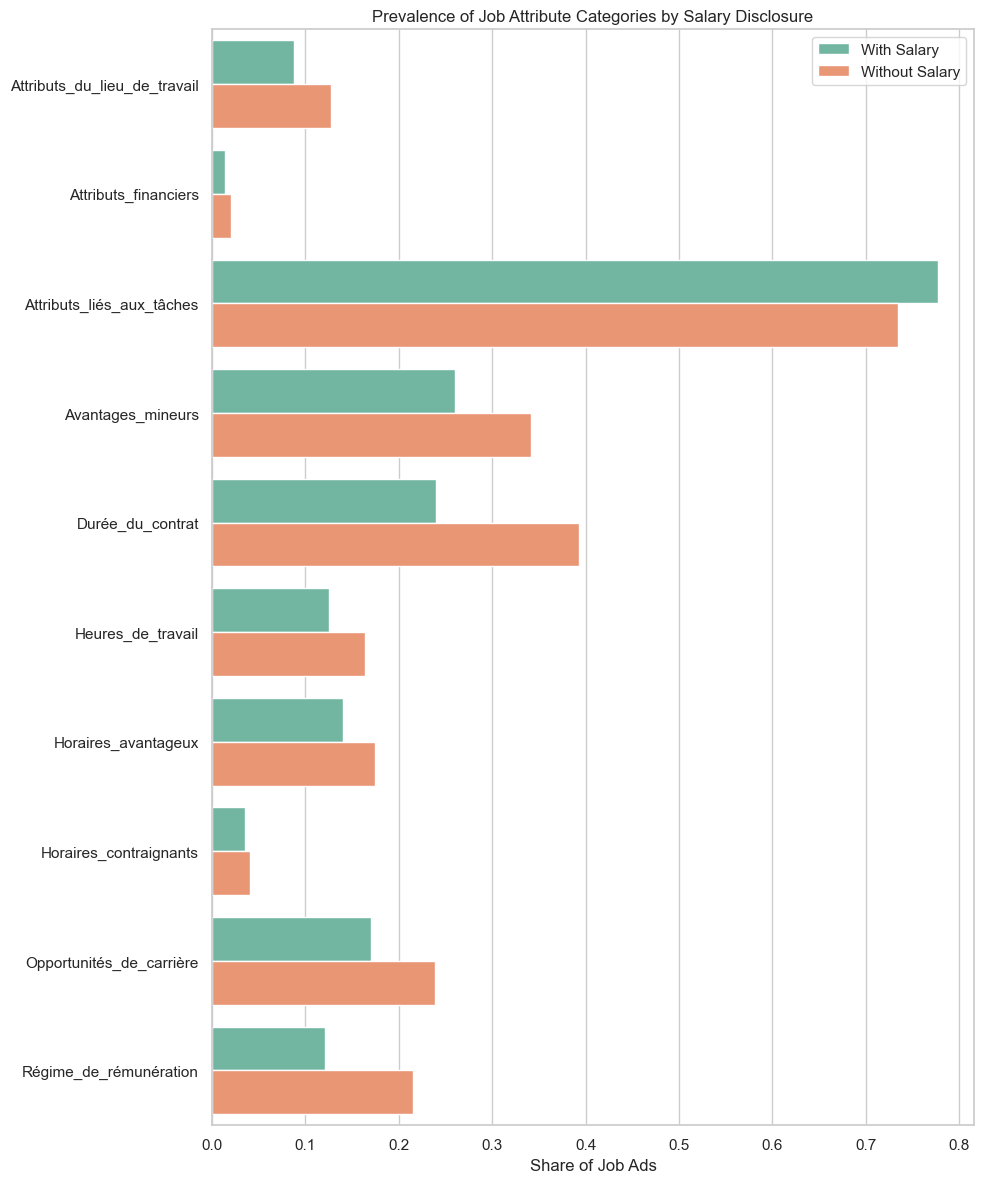

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir a formato largo para seaborn
melted = comparison_df.melt(id_vars="Attribute", value_vars=["With Salary", "Without Salary"], var_name="Salary Disclosure", value_name="Share")

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(data=melted, x="Share", y="Attribute", hue="Salary Disclosure", palette="Set2")
plt.title("Prevalence of Job Attribute Categories by Salary Disclosure")
plt.xlabel("Share of Job Ads")
plt.ylabel("")
plt.legend(title="")
plt.tight_layout()
plt.show()


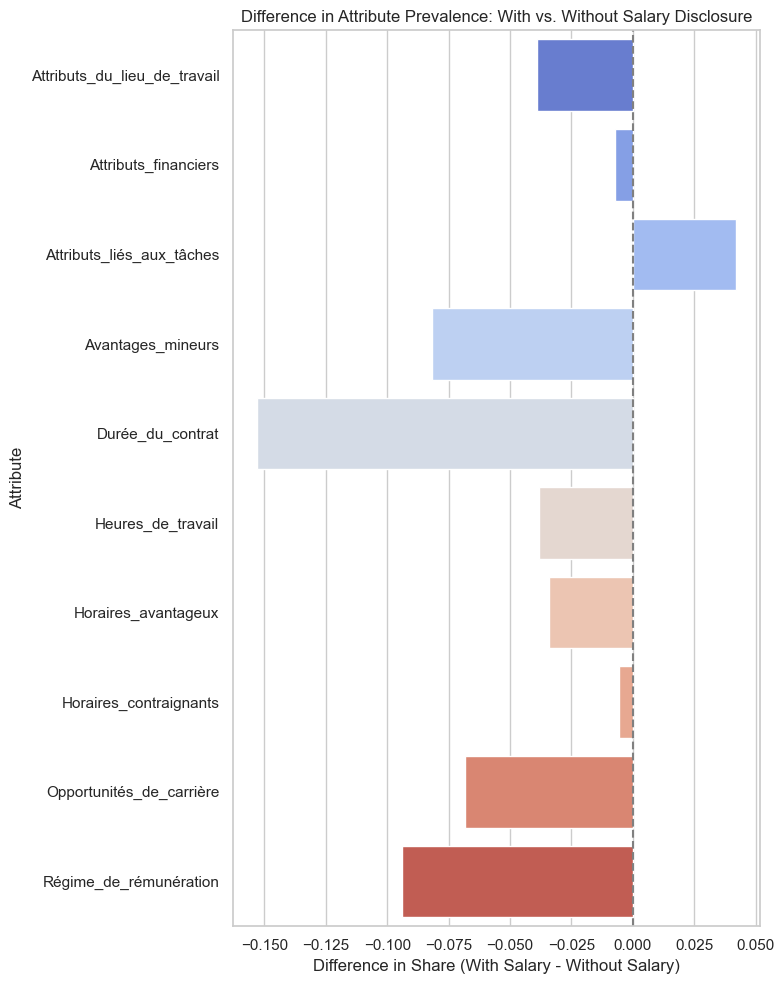

In [68]:
plt.figure(figsize=(8, 10))
sns.barplot(data=comparison_df, x="Difference", y="Attribute", palette="coolwarm")
plt.axvline(0, color='gray', linestyle='--')
plt.title("Difference in Attribute Prevalence: With vs. Without Salary Disclosure")
plt.xlabel("Difference in Share (With Salary - Without Salary)")
plt.tight_layout()
plt.show()


Positive values → most frequent attribute when salary is published.

Negative values → most frequent attribute when no salary is published.

You can find strategic compensation patterns (ex: more benefits when no salary?).

In [69]:
# Detect valid subattributes: binary dummies, not 'agg_' and not 'is_salary'
sub_attributes = [
    col for col in df_sample.columns
    if not col.startswith("agg_")
    and col != "is_salary"
    and df_sample[col].dropna().isin([0, 1]).all()
    and df_sample[col].nunique() > 1
]


In [70]:
# Calculate average presence of each subattribute in both subsets
share_disclosed = df_salary_disclosed[sub_attributes].mean().rename("With Salary")
share_hidden = df_salary_hidden[sub_attributes].mean().rename("Without Salary")

# Combine into a single DataFrame
comparison_df_sub = pd.concat([share_disclosed, share_hidden], axis=1)
comparison_df_sub["Difference"] = comparison_df_sub["With Salary"] - comparison_df_sub["Without Salary"]

# Reset index for plotting
comparison_df_sub = comparison_df_sub.reset_index().rename(columns={"index": "Attribute"})


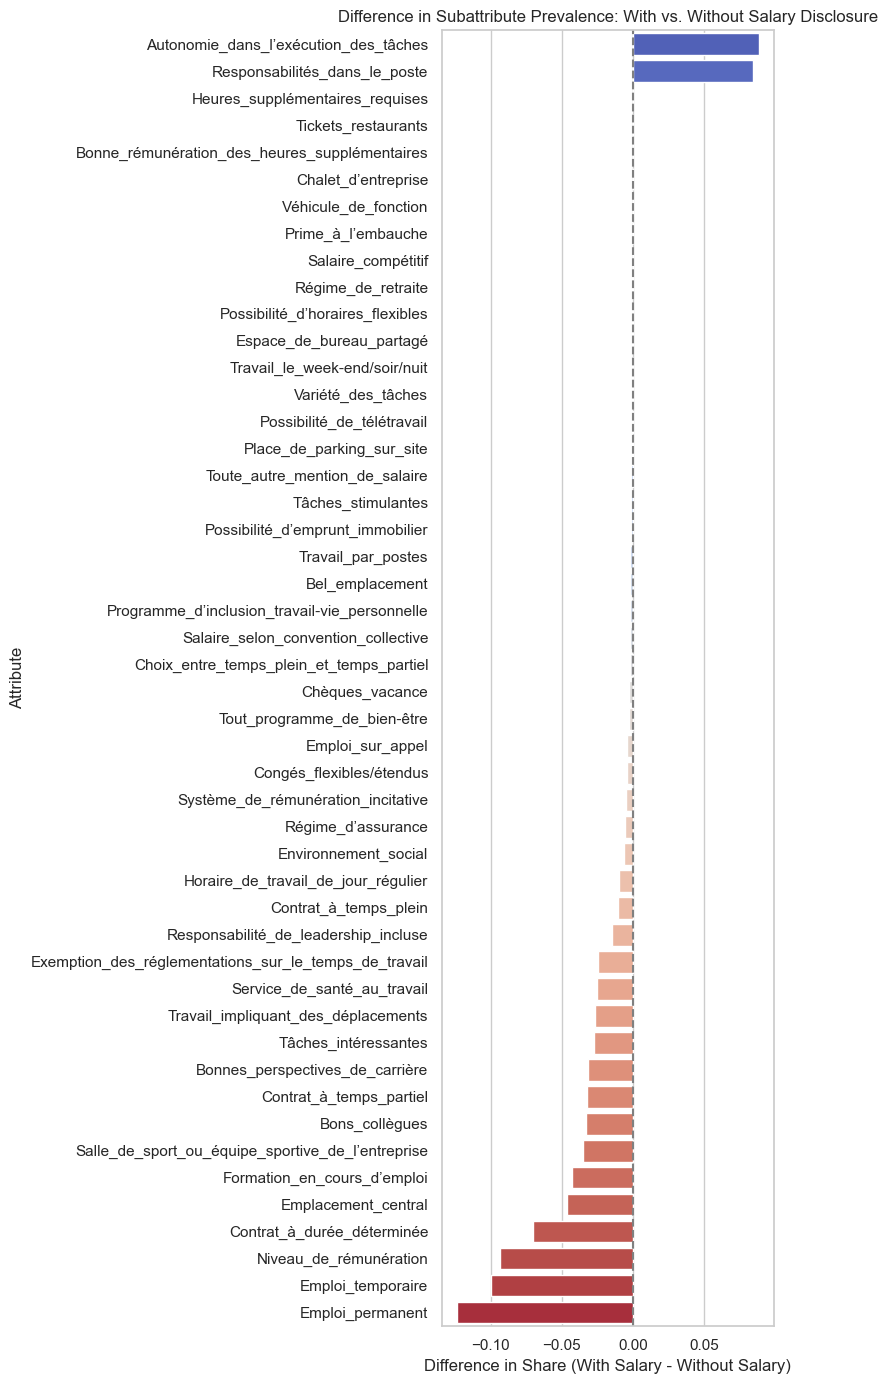

In [73]:
# Sort by absolute difference (opcional: usa abs si quieres orden por magnitud)
comparison_df_sub_sorted = comparison_df_sub.sort_values(by="Difference", ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 14))
sns.barplot(
    data=comparison_df_sub_sorted, 
    x="Difference", 
    y="Attribute", 
    palette="coolwarm"
)

plt.axvline(0, color='gray', linestyle='--')
plt.title("Difference in Subattribute Prevalence: With vs. Without Salary Disclosure")
plt.xlabel("Difference in Share (With Salary - Without Salary)")
plt.tight_layout()
plt.show()


## Looking into significance

In [74]:
from statsmodels.stats.proportion import proportions_ztest

# Inicializamos lista para p-valores
p_values = []

for attr in comparison_df_sub["Attribute"]:
    # Número de casos positivos en cada grupo
    count_salary = df_salary_disclosed[attr].sum()
    count_nosalary = df_salary_hidden[attr].sum()
    
    # Total observaciones en cada grupo
    n_salary = df_salary_disclosed.shape[0]
    n_nosalary = df_salary_hidden.shape[0]
    
    # Ejecutar z-test
    count = [count_salary, count_nosalary]
    nobs = [n_salary, n_nosalary]
    
    try:
        stat, pval = proportions_ztest(count, nobs)
    except:
        pval = 1.0  # Si hay error (como división por cero), asumimos no significativo
    
    p_values.append(pval)

# Agregar al DataFrame
comparison_df_sub["p_value"] = p_values


In [75]:
# Filtrar por significancia (por ejemplo p < 0.05)
significant_diff_df = comparison_df_sub[comparison_df_sub["p_value"] < 0.05]

# Ordenar por la diferencia
significant_diff_df = significant_diff_df.sort_values(by="Difference", ascending=False)


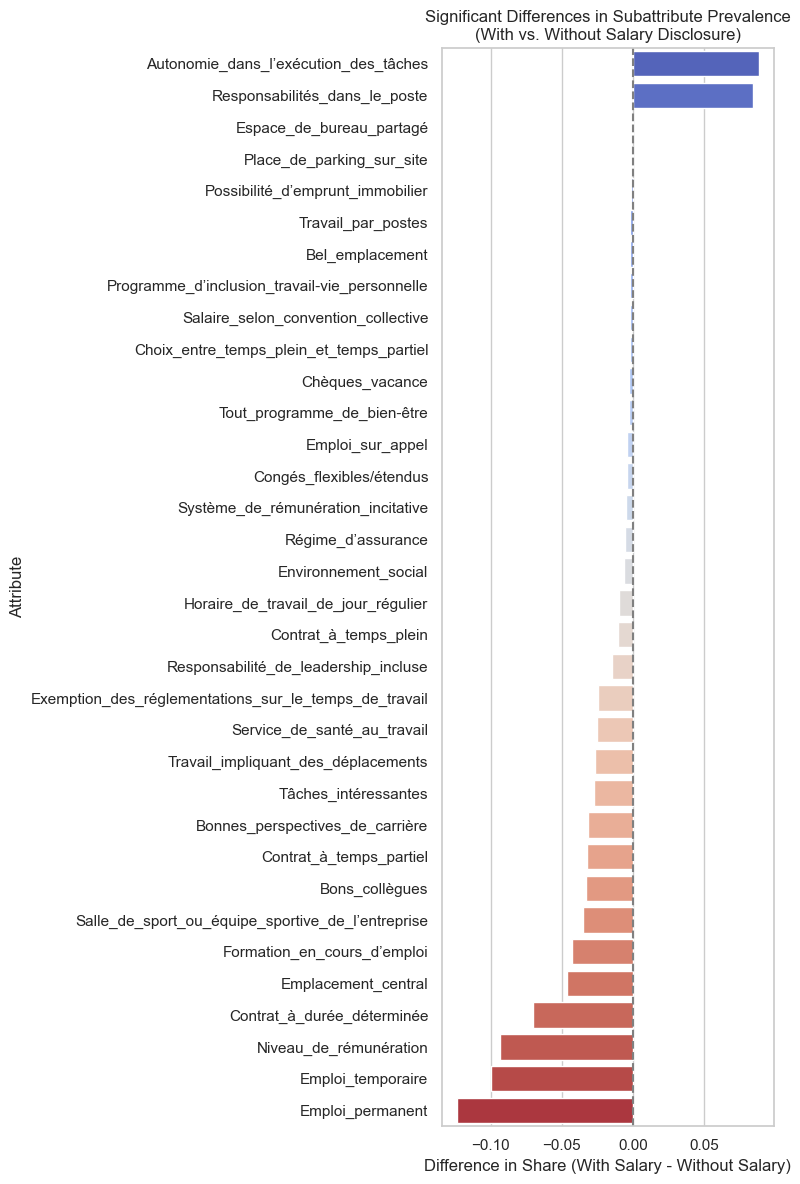

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12))
sns.barplot(
    data=significant_diff_df, 
    x="Difference", 
    y="Attribute", 
    palette="coolwarm"
)

plt.axvline(0, color='gray', linestyle='--')
plt.title("Significant Differences in Subattribute Prevalence\n(With vs. Without Salary Disclosure)")
plt.xlabel("Difference in Share (With Salary - Without Salary)")
plt.tight_layout()
plt.show()
